## Try for a frame

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from moviepy.editor import VideoFileClip as vfc
from IPython.display import HTML

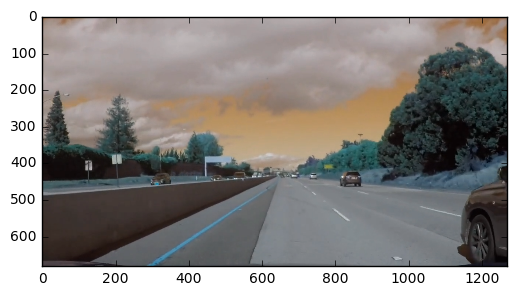

In [146]:
img = cv2.imread('challenge_lane6.jpg')
plt.imshow(img)

In [147]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

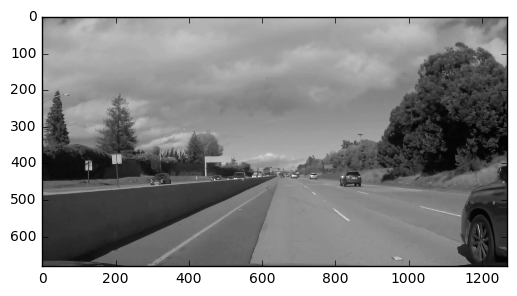

In [148]:
plt.imshow(gray_img, cmap='gray')

In [209]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

In [241]:
l_yellow = np.array([10, 0, 50], dtype='uint8')
u_yellow = np.array([50, 255, 255], dtype='uint8')

mask_yellow = cv2.inRange(img_hsv, l_yellow, u_yellow)
mask_white = cv2.inRange(gray_img, 170, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(gray_img, mask_yw)

In [242]:
kernel_size = 5
guass_gray = cv2.GaussianBlur(mask_yw_image, (5,5), 0)

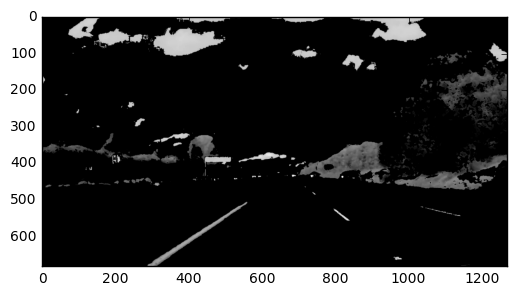

In [243]:
plt.imshow(guass_gray, cmap='gray')

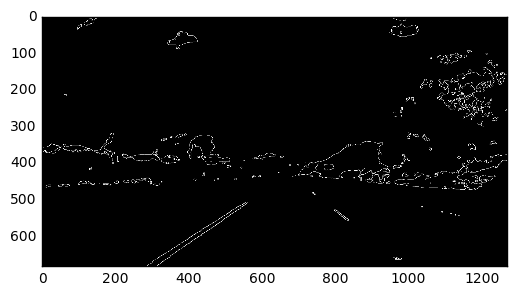

In [213]:
canny_img = cv2.Canny(guass_gray, 50, 150)
plt.imshow(canny_img, cmap='gray')

In [214]:
def ROI(img, vertices):
    
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
        
    else:
        ignore_mask_color = 255
    
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

In [215]:
imshape = img.shape

lower_left = [imshape[1] / 9, imshape[0]]
lower_right = [imshape[1] - imshape[1] / 9,imshape[0]]
top_left = [imshape[1] / 2 - imshape[1] / 8, imshape[0] / 2 + imshape[0] / 10]
top_right = [imshape[1]/2+imshape[1]/8,imshape[0] / 2 + imshape[0]/10]
vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]

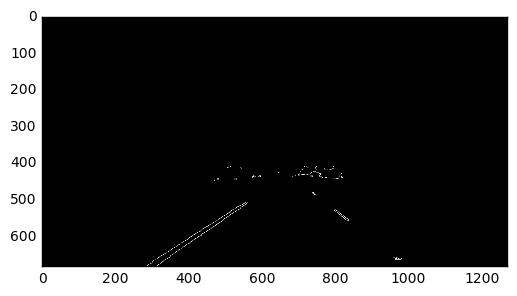

In [216]:
roi_image = ROI(canny_img, vertices)
if(len(canny_img.shape) > 2):
    print("What")
plt.imshow(roi_image, cmap='gray')

In [389]:
def get_slope(x1, y1, x2, y2):
    return (y2 - y1) / (x2 - x1 + 1e-5)
        

In [390]:
def get_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    global first_frame
    global cache
    
    right_lane_slope = []
    right_lane = []
    
    left_lane_slope = []
    left_lane = []
    
    global_min_y = img.shape[0]
    max_y = img.shape[0] * 0.7
    
    some_slope = 0.5
    alpha = 0.2
    
    right_intercept_arr = []
    left_intercept_arr = []
    
    try:
        
        for line in lines:
        
            for x1, y1, x2, y2 in line:
                if x1 == x2:
                    pass
                
                slope = get_slope(x1, y1, x2, y2)
                intercept = y1 - slope * x1
            
                if slope > some_slope and slope < 1:
                    
                    if x1 > 500:
                        
                        right_lane_slope.append(slope)
                        right_intercept_arr.append(intercept)
                        right_lane.append(line)
                
                elif slope < -some_slope and slope > -1:
                    
                    if x1 < 600:
                        
                        left_lane_slope.append(slope)
                        left_lane.append(line)
                        left_intercept_arr.append(intercept)
                    
                    
            #global_min_y = min(y1, y2, global_min_y)
            
    except:
        pass
    
    
    if(len(left_lane) == 0 or len(right_lane) == 0):
        #print("No lane found")
        cv2.line(img, (int(cache[0]), int(cache[1])), (int(cache[2]),int(cache[3])), color, thickness)
        cv2.line(img, (int(cache[4]), int(cache[5])), (int(cache[6]),int(cache[7])), color, thickness)
        return -1
    
    left_slope_mean = np.mean(left_lane_slope, axis = 0)
    right_slope_mean = np.mean(right_lane_slope, axis = 0)
    
    left_mean = np.mean(np.array(left_lane), axis = 0)
    right_mean = np.mean(np.array(right_lane), axis = 0)
    
    if(right_slope_mean == 0 or left_slope_mean == 0):
        print('Slope is 0')
        return -1
    
    left_intercept1 = left_mean[0][1] - (left_slope_mean * left_mean[0][0])
    right_intercept1 = right_mean[0][1] - (right_slope_mean * right_mean[0][0])
    
    left_intercept2 = np.mean(left_intercept_arr, axis = 0)
    right_intercept2 = np.mean(right_intercept_arr, axis = 0)
    
    left_intercept = (left_intercept1 + left_intercept2) / 2
    right_intercept = (right_intercept1 + right_intercept2) / 2
        
    
    lx1 = int((global_min_y - left_intercept) / left_slope_mean)
    lx2 = int((max_y - left_intercept) / left_slope_mean)
    
    rx1 = int((global_min_y - right_intercept) / right_slope_mean)
    rx2 = int((max_y - right_intercept) / right_slope_mean)
    
    left_lane_slope = np.mean(left_lane_slope[-100:])
    left_lane_intercept = np.mean(left_intercept_arr[-100:])
    right_lane_slope = np.mean(right_lane_slope[-50:])
    right_lane_intercept = np.mean(right_intercept_arr[-50:])
    
    if lx1 > rx1:
        
        lx1 = int((lx1 + rx1) / 2)
        rx1 = lx1
        
        ly1 = int((left_lane_slope * lx1) + left_lane_intercept)
        ly2 = int((left_lane_slope * lx2) + left_lane_intercept)
        
        ry1 = int((right_lane_slope * rx1) + right_lane_intercept)
        ry2 = int((right_lane_slope * rx2) + right_lane_intercept)
    
    else:
        
        ly1 = global_min_y
        ly2 = max_y
        
        ry1 = global_min_y
        ry2 = max_y
    
    current_frame = np.array([lx1, ly1, lx2, ly2, rx1, ry1, rx2, ry2], dtype='float32')
    
    if first_frame == 1:
        next_frame = current_frame
        first_frame = 0
        
    else:
        prev_frame = cache
        next_frame = (1- alpha) * prev_frame + alpha * current_frame
    
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, thickness)
    
    cache = next_frame
    


In [391]:
def weighted_img(img, prev_img, alpha = 0.7, beta = 1., gamma = 0.):
    return cv2.addWeighted(prev_img, alpha, img, beta, gamma)

In [392]:
def hough_transform(img, rho, theta, thresh, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, thresh, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if lines is not None:
        get_lines(line_img, lines)
        
    #print(lines)
        
    return line_img
    
    

In [411]:
global first_frame
first_frame = 1
hough_img = hough_transform(canny_img, 2, np.pi / 180, 20, 70, 190)

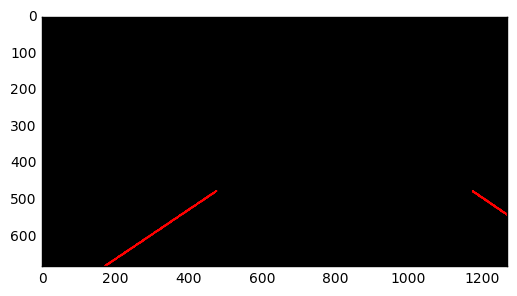

In [412]:
plt.imshow(hough_img)

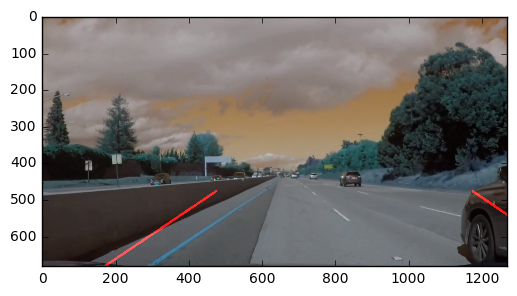

In [413]:
weighted_image = weighted_img(hough_img, img, alpha=0.9, beta = 1, gamma = 0.)
plt.imshow(weighted_image)

In [414]:
def mark_image(img):
    
    global first_frame
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    l_yellow = np.array([10, 0, 65], dtype='uint8')
    u_yellow = np.array([45, 250, 255], dtype='uint8')

    mask_yellow = cv2.inRange(img_hsv, l_yellow, u_yellow)
    mask_white = cv2.inRange(gray_img, 170, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray_img, mask_yw)
    
    kernel_size = 5
    guass_gray = cv2.GaussianBlur(mask_yw_image, (5,5), 0)
    
    canny_img = cv2.Canny(guass_gray, 50, 150)
    
    imshape = img.shape

    lower_left = [imshape[1] / 9, imshape[0]]
    lower_right = [imshape[1] - imshape[1] / 9,imshape[0]]
    
    top_left = [imshape[1] / 2 - imshape[1] / 8, imshape[0] / 2 + imshape[0] / 10]
    top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]
    
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
    
    #print(vertices)
    
    roi_image = ROI(canny_img, vertices)
    
    hough_img = hough_transform(roi_image, 2, np.pi / 180, 20, 70, 190)
    
    weighted_image = weighted_img(hough_img, img, alpha=0.9, beta = 1, gamma = 0.)
    
    return weighted_image

In [415]:
first_frame = 1
white_output = 'challenge.mp4'
clip = vfc('challenge_video.mp4')

In [416]:
white_clip = clip.fl_image(mark_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4



100%|██████████| 485/485 [00:23<00:00, 22.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 

CPU times: user 12 s, sys: 1.93 s, total: 13.9 s
Wall time: 24.7 s
